In [1]:
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

In [2]:
import opendatasets as od
import os
import random
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time

In [3]:
dataset_url = 'https://www.kaggle.com/datasets/andrewmvd/pediatric-pneumonia-chest-xray'
od.download(dataset_url)

# Assume `od.download(dataset_url)` is a function to download and extract the dataset

def load_images_from_directory(directory):
    images, labels = [], []
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            for file_name in os.listdir(label_path):
                if file_name.endswith(".jpeg"):
                    image_path = os.path.join(label_path, file_name)
                    image = cv2.imread(image_path)
                    if image is not None:
                        # Resize image and convert to array
                        image = cv2.resize(image, (32, 32))
                        image = img_to_array(image)
                        images.append(image)
                        labels.append(label)  # Use folder name as label
    # Convert lists to numpy arrays and normalize pixel values
    return np.array(images, dtype="float") / 255.0, np.array(labels)

# Define paths for train and test sets
train_path = '/content/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/train'
test_path = '/content/pediatric-pneumonia-chest-xray/Pediatric Chest X-ray Pneumonia/test'

# Load and preprocess the datasets
x_train, y_train = load_images_from_directory(train_path)
x_test, y_test = load_images_from_directory(test_path)

# Convert string labels to integer labels using LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)  # Converts 'NORMAL'/'PNEUMONIA' to integers
y_test = label_encoder.transform(y_test)

# Convert integer labels to one-hot encoding
num_classes = len(label_encoder.classes_)  # Calculate number of classes
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Check loaded data
print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}')
print("Classes:", label_encoder.classes_)

# Model definitions (teacher and student models would be defined here as in your code)
# ...


# Display the classes for verification
print("Classes:", label_encoder.classes_)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: harzh01
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/pediatric-pneumonia-chest-xray


100%|██████████| 1.14G/1.14G [00:11<00:00, 111MB/s] 



Training samples: 5232, Testing samples: 624
Classes: ['NORMAL' 'PNEUMONIA']
Classes: ['NORMAL' 'PNEUMONIA']


In [4]:
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.models import Model

def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # First block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = AveragePooling2D((2, 2))(x)

    # Second block
    x = Conv2D(128, (5, 5), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Third block
    x = Conv2D(256, (3, 3), activation='relu', padding='valid')(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D((2, 2))(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # First block
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Second block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D((2, 2))(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


input_shape = (32, 32, 3)  # Updated input shape



In [5]:
teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Define a learning rate scheduler function
def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Compile and train the teacher model
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Precompute teacher's predictions for distillation
teacher_preds = teacher.predict(x_train)

Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.8482 - loss: 0.4424 - val_accuracy: 0.6282 - val_loss: 1.2819 - learning_rate: 0.0100
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9342 - loss: 0.1605 - val_accuracy: 0.7308 - val_loss: 1.0927 - learning_rate: 0.0100
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9548 - loss: 0.1227 - val_accuracy: 0.7452 - val_loss: 0.8772 - learning_rate: 0.0100
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9670 - loss: 0.0981 - val_accuracy: 0.7708 - val_loss: 0.8174 - learning_rate: 0.0100
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9705 - loss: 0.0827 - val_accuracy: 0.7388 - val_loss: 1.1018 - learning_rate: 0.0100
Epoch 6/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9704 - loss: 0.0775 - val_accuracy: 0.7083 - val_loss: 1.4643 - learning_rate: 0.0100
Epoch 7/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9695 - loss: 0.0734

In [6]:


def distillation_loss(y_true, y_pred, teacher_preds, temperature=5.0, alpha=0.3):
    # Adjust temperature for teacher and student predictions
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_pred_soft = tf.keras.activations.softmax(y_pred / temperature)
    teacher_batch_preds_soft = tf.keras.activations.softmax(teacher_batch_preds / temperature)

    # Compute KL divergence for soft loss
    soft_loss = tf.keras.losses.KLDivergence()(teacher_batch_preds_soft, y_pred_soft)

    # Compute categorical cross-entropy for hard loss
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    # Weighted combination of soft and hard losses
    return alpha * soft_loss + (1. - alpha) * hard_loss


In [7]:
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

Teacher test accuracy: 74.20%


In [8]:
student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds), metrics=['accuracy'])
student.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

Epoch 1/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 12s 46ms/step - accuracy: 0.8517 - loss: 0.4192 - val_accuracy: 0.6250 - val_loss: 1.8344 - learning_rate: 0.0010
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9621 - loss: 0.0765 - val_accuracy: 0.6250 - val_loss: 2.2726 - learning_rate: 0.0010
Epoch 3/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9626 - loss: 0.0727 - val_accuracy: 0.6747 - val_loss: 1.2196 - learning_rate: 0.0010
Epoch 4/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9692 - loss: 0.0589 - val_accuracy: 0.6058 - val_loss: 0.9697 - learning_rate: 0.0010
Epoch 5/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9714 - loss: 0.0564 - val_accuracy: 0.6298 - val_loss: 5.5939 - learning_rate: 0.0010
Epoch 6/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9782 - loss: 0.0492 - val_accuracy: 0.6474 - val_loss: 1.9901 - learning_rate: 0.0010
Epoch 7/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9810 - loss: 0.0430 

In [9]:
# Evaluate models
#teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
student_score = student.evaluate(x_test, y_test, verbose=0)
#print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')
print(f'Student test accuracy: {student_score[1] * 100:.2f}%')

Student test accuracy: 78.53%


In [10]:
# Evaluate the teacher model
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)

print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

# Generate predictions from the teacher model
teacher_preds_probs = teacher.predict(x_test)
teacher_preds = np.argmax(teacher_preds_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print the classification report for the teacher model
print("=== Teacher Model Classification Report ===")
print(classification_report(y_true, teacher_preds, target_names=label_encoder.classes_))

Teacher test accuracy: 74.20%
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
=== Teacher Model Classification Report ===
              precision    recall  f1-score   support

      NORMAL       0.97      0.32      0.48       234
   PNEUMONIA       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.74      0.70       624



In [11]:
alpha_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
temperature_values = [1.0, 2.0, 5.0, 10.0]  # Adjust temperature values as needed

results = []  # To store results for each combination of alpha and temperature

teacher_preds = teacher.predict(x_train)

# Function to evaluate F1-score, accuracy, precision, recall, and inference time for a given alpha and temperature
def evaluate_student(alpha, temperature):
    def distillation_loss(y_true, y_pred, teacher_preds, temperature=temperature, alpha=alpha):
        teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
        y_pred_soft = tf.keras.activations.softmax(y_pred / temperature)
        teacher_batch_preds_soft = tf.keras.activations.softmax(teacher_batch_preds / temperature)

        soft_loss = tf.keras.losses.KLDivergence()(teacher_batch_preds_soft, y_pred_soft)
        hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        return alpha * soft_loss + (1. - alpha) * hard_loss

    student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds),
                    metrics=['accuracy'])

    student.fit(x_train, y_train, batch_size=32, epochs=8, validation_data=(x_test, y_test),
                callbacks=[LearningRateScheduler(lr_scheduler)], verbose=0)

    start_time = time.time()
    y_pred_probs = student.predict(x_test)
    inference_time = time.time() - start_time
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Store the results in the dictionary
    results.append({
        "alpha": alpha,
        "temperature": temperature,
        "f1_score": f1,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "inference_time": inference_time
    })

    print(f"=== Alpha: {alpha}, Temperature: {temperature} ===")
    print(f"F1 Score: {f1:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(f"Inference Time: {inference_time:.4f} seconds\n")

# Run evaluation for each combination of alpha and temperature
for alpha in alpha_values:
    for temperature in temperature_values:
        evaluate_student(alpha, temperature)

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== Alpha: 0.0, Temperature: 1.0 ===
F1 Score: 0.4808, Accuracy: 0.6250, Precision: 0.3906, Recall: 0.6250
Inference Time: 2.6547 seconds

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
=== Alpha: 0.0, Temperature: 2.0 ===
F1 Score: 0.6964, Accuracy: 0.7420, Precision: 0.8174, Recall: 0.7420
Inference Time: 0.6841 seconds

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
=== Alpha: 0.0, Temperature: 5.0 ===
F1 Score: 0.8520, Accuracy: 0.8542, Precision: 0.8538, Recall: 0.8542
Inference Time: 0.7820 seconds

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
=== Alpha: 0.0, Temperature: 10.0 ===
F1 Score: 0.7167, Accuracy: 0.7532, Precision: 0.8080, Recall: 0.7532
Inference Time: 0.6811 seconds

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
=== Alpha: 0.1, Temperature: 1.0 ===
F1 Score: 0.7383, Accuracy: 0.7692, Precision: 0.8214, Recall: 0.7692
Inference Time: 0.6987 seconds

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
=== Alpha: 0.1, Temperature: 2.0 ===
F1 Score: 0.7195, Accuracy: 0.7564, Precision: 0.8170, Recall: 0.75

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
=== Alpha: 1.0, Temperature: 2.0 ===
F1 Score: 0.2045, Accuracy: 0.3750, Precision: 0.1406, Recall: 0.3750
Inference Time: 0.6855 seconds



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
=== Alpha: 1.0, Temperature: 5.0 ===
F1 Score: 0.2045, Accuracy: 0.3750, Precision: 0.1406, Recall: 0.3750
Inference Time: 0.6837 seconds



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
=== Alpha: 1.0, Temperature: 10.0 ===
F1 Score: 0.2045, Accuracy: 0.3750, Precision: 0.1406, Recall: 0.3750
Inference Time: 1.3458 seconds



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


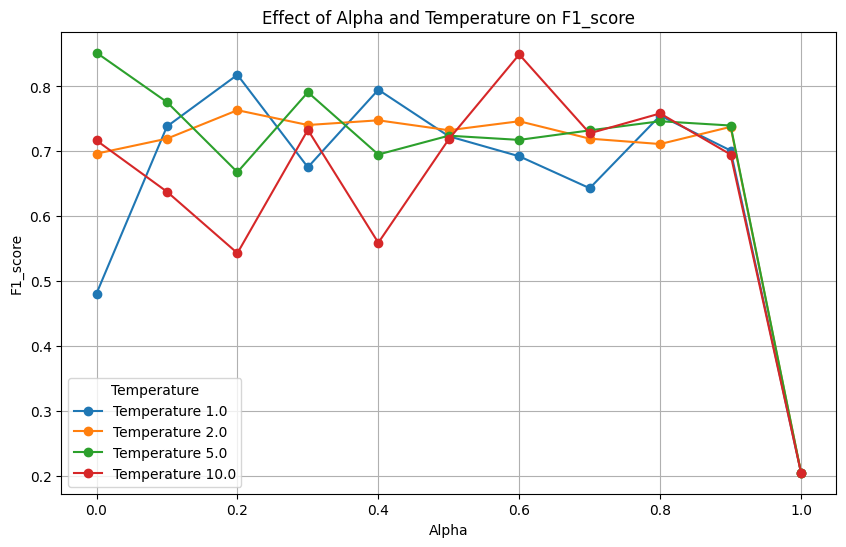

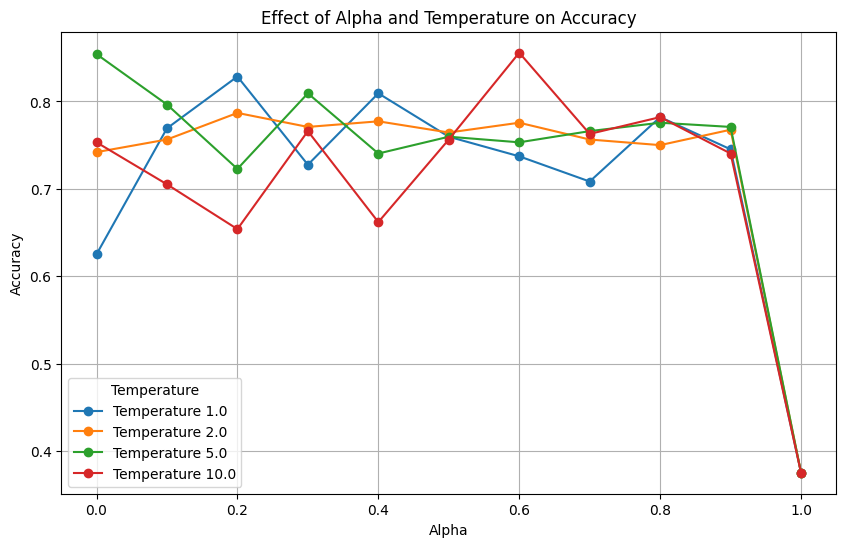

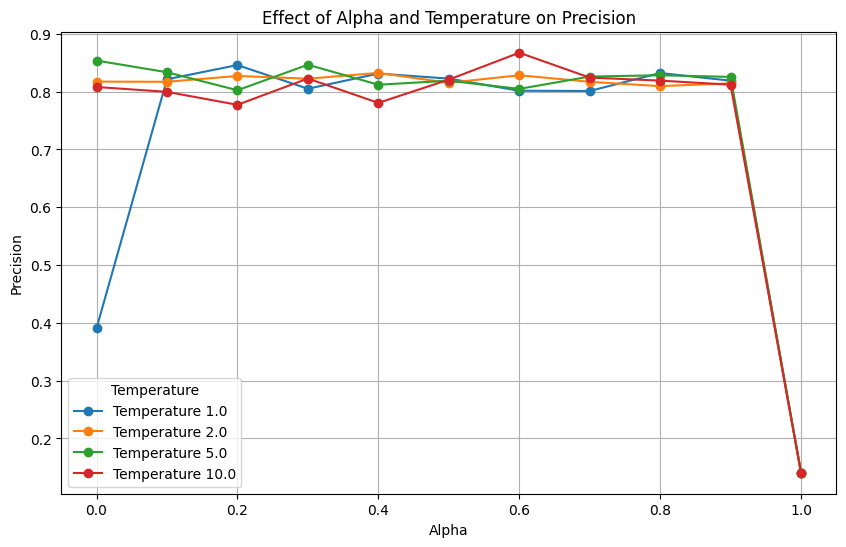

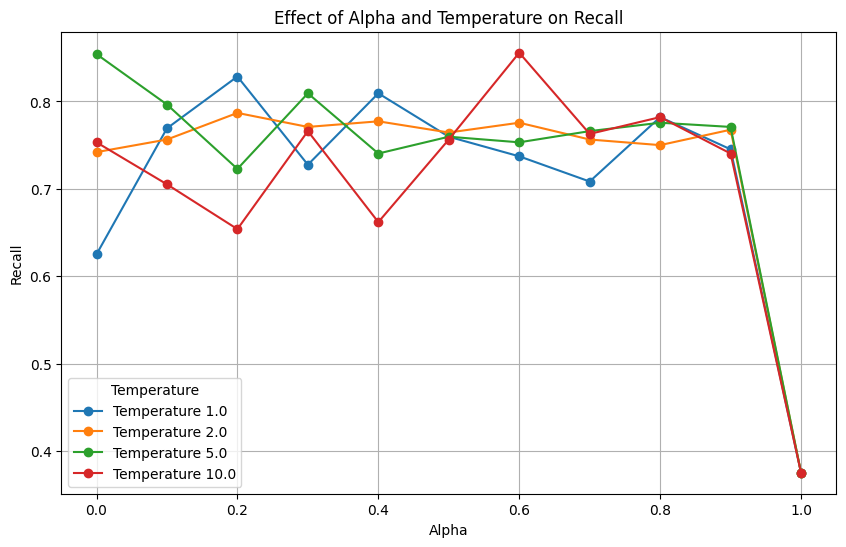

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Example results data (replace this with your actual results)
# results = [
#     {"alpha": 0.0, "temperature": 1.0, "f1_score": 0.75, "accuracy": 0.8, "precision": 0.78, "recall": 0.76, "inference_time": 0.05},
#     {"alpha": 0.1, "temperature": 1.0, "f1_score": 0.76, "accuracy": 0.81, "precision": 0.79, "recall": 0.77, "inference_time": 0.06},
#     ...
# ]

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Create subplots for each metric
metrics = ['f1_score', 'accuracy', 'precision', 'recall']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    for temp in results_df['temperature'].unique():
        subset = results_df[results_df['temperature'] == temp]
        plt.plot(subset['alpha'], subset[metric], marker='o', label=f'Temperature {temp}')

    plt.title(f'Effect of Alpha and Temperature on {metric.capitalize()}')
    plt.xlabel('Alpha')
    plt.ylabel(metric.capitalize())
    plt.legend(title="Temperature")
    plt.grid(True)
    plt.show()
